In [1]:
!pip install astroNN --quiet

In [2]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.transforms import v2 as transforms
from astroNN.datasets import galaxy10
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split

In [3]:
images, labels = galaxy10.load_data()
images = np.transpose(images, axes=(0, 3, 1, 2))

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [02:02<00:00, 21.3MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [02:10, 21.0MB/s]                            


In [4]:
class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
class MorphologicalOpeningTransform(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    
    def forward(self, img):
        np_img = img if isinstance(img, np.ndarray) else img.numpy()
        morphs = []
        for ch in range(3):
            morphs.append(
                torch.from_numpy(
                    cv2.morphologyEx(np_img[ch], cv2.MORPH_OPEN, self.kernel)
                )
            )

        return torch.stack(morphs)

In [6]:
N_CH, IMG_HEIGHT, IMG_WIDTH = 3, 224, 224

In [7]:
transform = transforms.Compose([
    MorphologicalOpeningTransform((7,7)),
    transforms.RandomRotation(degrees=180),
    transforms.CenterCrop(size=(IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToDtype(torch.float),
    transforms.Normalize(mean=(127.5, 127.5, 127.5), std=(127.5, 127.5, 127.5))
])

In [8]:
dataset = Galaxy10Dataset(images, labels, transform=transform)

train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, shuffle=True, stratify=dataset.labels)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Cargo modelo DenseNet121 preentrenado
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Reemplazo la última capa para las 10 clases de Galaxy10 DECaLS
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 10)

# Muevo el modelo a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 195MB/s]


In [10]:
class EarlyStopping:
  def __init__(self, tolerance=5, min_delta=0):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.early_stop = False

  def __call__(self, train_loss, validation_loss):
    if (validation_loss - train_loss) > self.min_delta:
      self.counter += 1
      if self.counter >= self.tolerance:
        self.early_stop = True

In [11]:
import torch.optim as optim
from sklearn import metrics

# Configuración de criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.1 ** (epoch / 10))
early_stopping = EarlyStopping(tolerance=10, min_delta=0.01)

In [12]:
from tqdm import tqdm

epochs = 50

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

train_accuracy_by_epoch=[]
valid_accuracy_by_epoch=[]

train_precision_by_epoch=[]
valid_precision_by_epoch=[]

train_recall_by_epoch=[]
valid_recall_by_epoch=[]

for epoch in tqdm(range(1, epochs + 1)):

  ############################################
  ## Entrenamiento
  ############################################
  model.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []

  for data in train_loader:
    x_batch, y_batch = data
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).long()

    optimizer.zero_grad()
    nnet_output = model(x_batch)
    y_batch_hat = torch.argmax(nnet_output, dim=1)

    loss = criterion(nnet_output, y_batch)

    loss.backward()

    optimizer.step()

    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())

    epoch_loss += loss.item()

  epoch_loss = epoch_loss / len(train_dataset)
  train_loss_by_epoch.append(epoch_loss)

  train_precision = metrics.precision_score(epoch_y, epoch_y_hat, average=None)
  train_precision_by_epoch.append(train_precision)

  train_recall = metrics.recall_score(epoch_y, epoch_y_hat, average=None)
  train_recall_by_epoch.append(train_recall)

  train_accuracy = metrics.accuracy_score(epoch_y, epoch_y_hat)
  train_accuracy_by_epoch.append(train_accuracy)

  ############################################
  ## Validación
  ############################################
  model.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for data in test_loader:
    x_batch, y_batch = data
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).long()

    nnet_output = model(x_batch)
    y_batch_hat = torch.argmax(nnet_output, dim=1)

    loss = criterion(nnet_output, y_batch)

    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())

    valid_epoch_loss += loss.item()

  valid_epoch_loss = valid_epoch_loss / len(test_dataset)

  if(valid_epoch_loss < min(valid_loss_by_epoch, default=np.inf)):
    torch.save(model.state_dict(), 'densenet.pt')
    print("--- New model saved ---")

  valid_loss_by_epoch.append(valid_epoch_loss)

  valid_precision = metrics.precision_score(valid_epoch_y, valid_epoch_y_hat, average=None)
  valid_precision_by_epoch.append(valid_precision)

  valid_recall = metrics.recall_score(valid_epoch_y, valid_epoch_y_hat, average=None)
  valid_recall_by_epoch.append(valid_recall)

  valid_accuracy = metrics.accuracy_score(valid_epoch_y, valid_epoch_y_hat)
  valid_accuracy_by_epoch.append(valid_accuracy)

  early_stopping(epoch_loss, valid_epoch_loss)
  if early_stopping.early_stop:
    print("Early stopping")
    break

  scheduler.step()

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.5f} / {valid_epoch_loss:.5f} | " \
        f"Train/Valid accuracy: {train_accuracy:.5f} / {valid_accuracy:.5f}")

  2%|▏         | 1/50 [02:48<2:17:40, 168.58s/it]

--- New model saved ---
 Epoch 1 | Train/Valid loss: 0.03592 / 0.03239 | Train/Valid accuracy: 0.59445 / 0.65474


  4%|▍         | 2/50 [05:36<2:14:29, 168.12s/it]

--- New model saved ---
 Epoch 2 | Train/Valid loss: 0.02507 / 0.02650 | Train/Valid accuracy: 0.72646 / 0.71026


  6%|▌         | 3/50 [08:22<2:10:49, 167.00s/it]

--- New model saved ---
 Epoch 3 | Train/Valid loss: 0.02064 / 0.01928 | Train/Valid accuracy: 0.77594 / 0.79030


  8%|▊         | 4/50 [11:08<2:07:56, 166.89s/it]

--- New model saved ---
 Epoch 4 | Train/Valid loss: 0.01827 / 0.01801 | Train/Valid accuracy: 0.79800 / 0.80186


 10%|█         | 5/50 [13:57<2:05:39, 167.54s/it]

--- New model saved ---
 Epoch 5 | Train/Valid loss: 0.01659 / 0.01752 | Train/Valid accuracy: 0.82090 / 0.80158


 12%|█▏        | 6/50 [16:43<2:02:21, 166.86s/it]

--- New model saved ---
 Epoch 6 | Train/Valid loss: 0.01542 / 0.01579 | Train/Valid accuracy: 0.83141 / 0.82384


 14%|█▍        | 7/50 [19:27<1:59:04, 166.16s/it]

--- New model saved ---
 Epoch 7 | Train/Valid loss: 0.01429 / 0.01430 | Train/Valid accuracy: 0.84445 / 0.84273


 16%|█▌        | 8/50 [22:12<1:55:59, 165.71s/it]

--- New model saved ---
 Epoch 8 | Train/Valid loss: 0.01292 / 0.01419 | Train/Valid accuracy: 0.85897 / 0.84583


 18%|█▊        | 9/50 [24:57<1:53:09, 165.60s/it]

 Epoch 9 | Train/Valid loss: 0.01254 / 0.01469 | Train/Valid accuracy: 0.86411 / 0.83850


 20%|██        | 10/50 [27:42<1:50:08, 165.22s/it]

--- New model saved ---
 Epoch 10 | Train/Valid loss: 0.01163 / 0.01367 | Train/Valid accuracy: 0.87264 / 0.84386


 22%|██▏       | 11/50 [30:26<1:47:16, 165.03s/it]

--- New model saved ---
 Epoch 11 | Train/Valid loss: 0.01132 / 0.01302 | Train/Valid accuracy: 0.87750 / 0.85344


 24%|██▍       | 12/50 [33:11<1:44:29, 164.99s/it]

--- New model saved ---
 Epoch 12 | Train/Valid loss: 0.01057 / 0.01300 | Train/Valid accuracy: 0.88385 / 0.85682


 26%|██▌       | 13/50 [35:57<1:41:50, 165.14s/it]

--- New model saved ---
 Epoch 13 | Train/Valid loss: 0.01021 / 0.01252 | Train/Valid accuracy: 0.88871 / 0.85908


 28%|██▊       | 14/50 [38:42<1:39:10, 165.29s/it]

 Epoch 14 | Train/Valid loss: 0.00995 / 0.01276 | Train/Valid accuracy: 0.89012 / 0.86161


 30%|███       | 15/50 [41:28<1:36:29, 165.41s/it]

--- New model saved ---
 Epoch 15 | Train/Valid loss: 0.00943 / 0.01246 | Train/Valid accuracy: 0.89759 / 0.86246


 32%|███▏      | 16/50 [44:15<1:33:56, 165.78s/it]

--- New model saved ---
 Epoch 16 | Train/Valid loss: 0.00931 / 0.01241 | Train/Valid accuracy: 0.89703 / 0.86387


 34%|███▍      | 17/50 [47:02<1:31:22, 166.14s/it]

 Epoch 17 | Train/Valid loss: 0.00893 / 0.01247 | Train/Valid accuracy: 0.90097 / 0.86838


 36%|███▌      | 18/50 [49:47<1:28:31, 165.98s/it]

--- New model saved ---
 Epoch 18 | Train/Valid loss: 0.00895 / 0.01230 | Train/Valid accuracy: 0.90182 / 0.86077


 38%|███▊      | 19/50 [52:34<1:25:53, 166.24s/it]

 Epoch 19 | Train/Valid loss: 0.00869 / 0.01238 | Train/Valid accuracy: 0.90457 / 0.86528


 40%|████      | 20/50 [55:23<1:23:27, 166.92s/it]

--- New model saved ---
 Epoch 20 | Train/Valid loss: 0.00864 / 0.01213 | Train/Valid accuracy: 0.90555 / 0.87007


 42%|████▏     | 21/50 [58:09<1:20:40, 166.91s/it]

--- New model saved ---
 Epoch 21 | Train/Valid loss: 0.00870 / 0.01209 | Train/Valid accuracy: 0.90217 / 0.86894


 44%|████▍     | 22/50 [1:00:56<1:17:51, 166.85s/it]

 Epoch 22 | Train/Valid loss: 0.00864 / 0.01234 | Train/Valid accuracy: 0.90161 / 0.86471


 46%|████▌     | 23/50 [1:03:41<1:14:46, 166.17s/it]

 Epoch 23 | Train/Valid loss: 0.00845 / 0.01214 | Train/Valid accuracy: 0.90689 / 0.87148


 48%|████▊     | 24/50 [1:06:28<1:12:06, 166.39s/it]

 Epoch 24 | Train/Valid loss: 0.00846 / 0.01218 | Train/Valid accuracy: 0.90710 / 0.86781


 50%|█████     | 25/50 [1:09:12<1:09:04, 165.78s/it]

 Epoch 25 | Train/Valid loss: 0.00835 / 0.01231 | Train/Valid accuracy: 0.90682 / 0.86669


 52%|█████▏    | 26/50 [1:11:57<1:06:14, 165.59s/it]

 Epoch 26 | Train/Valid loss: 0.00840 / 0.01210 | Train/Valid accuracy: 0.90746 / 0.86697


 54%|█████▍    | 27/50 [1:14:42<1:03:24, 165.40s/it]

 Epoch 27 | Train/Valid loss: 0.00826 / 0.01245 | Train/Valid accuracy: 0.91035 / 0.86077


 56%|█████▌    | 28/50 [1:17:26<1:00:26, 164.84s/it]

 Epoch 28 | Train/Valid loss: 0.00842 / 0.01220 | Train/Valid accuracy: 0.90577 / 0.86415


 58%|█████▊    | 29/50 [1:20:12<57:50, 165.25s/it]  

 Epoch 29 | Train/Valid loss: 0.00825 / 0.01220 | Train/Valid accuracy: 0.91098 / 0.86894


 60%|██████    | 30/50 [1:22:55<54:52, 164.61s/it]

 Epoch 30 | Train/Valid loss: 0.00821 / 0.01227 | Train/Valid accuracy: 0.90915 / 0.86950


 62%|██████▏   | 31/50 [1:25:40<52:08, 164.65s/it]

 Epoch 31 | Train/Valid loss: 0.00817 / 0.01233 | Train/Valid accuracy: 0.90894 / 0.86979


 64%|██████▍   | 32/50 [1:28:24<49:20, 164.45s/it]

--- New model saved ---
 Epoch 32 | Train/Valid loss: 0.00820 / 0.01207 | Train/Valid accuracy: 0.91169 / 0.86781


 66%|██████▌   | 33/50 [1:31:06<46:27, 163.95s/it]

 Epoch 33 | Train/Valid loss: 0.00840 / 0.01219 | Train/Valid accuracy: 0.90802 / 0.86669


 68%|██████▊   | 34/50 [1:33:51<43:44, 164.01s/it]

 Epoch 34 | Train/Valid loss: 0.00827 / 0.01220 | Train/Valid accuracy: 0.90844 / 0.86584


 70%|███████   | 35/50 [1:36:34<40:58, 163.90s/it]

--- New model saved ---
 Epoch 35 | Train/Valid loss: 0.00806 / 0.01183 | Train/Valid accuracy: 0.91070 / 0.86866


 72%|███████▏  | 36/50 [1:39:18<38:14, 163.88s/it]

 Epoch 36 | Train/Valid loss: 0.00830 / 0.01230 | Train/Valid accuracy: 0.90971 / 0.86922


 74%|███████▍  | 37/50 [1:42:03<35:34, 164.22s/it]

 Epoch 37 | Train/Valid loss: 0.00825 / 0.01234 | Train/Valid accuracy: 0.90844 / 0.86725


 76%|███████▌  | 38/50 [1:44:47<32:48, 164.04s/it]

 Epoch 38 | Train/Valid loss: 0.00829 / 0.01224 | Train/Valid accuracy: 0.90894 / 0.86725


 78%|███████▊  | 39/50 [1:47:30<30:03, 163.95s/it]

 Epoch 39 | Train/Valid loss: 0.00826 / 0.01219 | Train/Valid accuracy: 0.90936 / 0.86809


 80%|████████  | 40/50 [1:50:15<27:19, 163.98s/it]

 Epoch 40 | Train/Valid loss: 0.00826 / 0.01236 | Train/Valid accuracy: 0.90816 / 0.86697


 82%|████████▏ | 41/50 [1:52:58<24:33, 163.77s/it]

 Epoch 41 | Train/Valid loss: 0.00817 / 0.01234 | Train/Valid accuracy: 0.91077 / 0.86584


 84%|████████▍ | 42/50 [1:55:41<21:47, 163.44s/it]

 Epoch 42 | Train/Valid loss: 0.00825 / 0.01222 | Train/Valid accuracy: 0.91056 / 0.86753


 86%|████████▌ | 43/50 [1:58:24<19:04, 163.56s/it]

 Epoch 43 | Train/Valid loss: 0.00839 / 0.01224 | Train/Valid accuracy: 0.90809 / 0.86669


 88%|████████▊ | 44/50 [2:01:08<16:22, 163.72s/it]

 Epoch 44 | Train/Valid loss: 0.00815 / 0.01225 | Train/Valid accuracy: 0.90964 / 0.86471


 90%|█████████ | 45/50 [2:03:52<13:37, 163.55s/it]

 Epoch 45 | Train/Valid loss: 0.00835 / 0.01215 | Train/Valid accuracy: 0.90880 / 0.86443


 92%|█████████▏| 46/50 [2:06:36<10:55, 163.79s/it]

 Epoch 46 | Train/Valid loss: 0.00831 / 0.01187 | Train/Valid accuracy: 0.90844 / 0.87345


 94%|█████████▍| 47/50 [2:09:19<08:10, 163.45s/it]

 Epoch 47 | Train/Valid loss: 0.00813 / 0.01234 | Train/Valid accuracy: 0.91042 / 0.86161


 96%|█████████▌| 48/50 [2:12:01<05:26, 163.20s/it]

 Epoch 48 | Train/Valid loss: 0.00823 / 0.01255 | Train/Valid accuracy: 0.91006 / 0.86753


 98%|█████████▊| 49/50 [2:14:45<02:43, 163.47s/it]

 Epoch 49 | Train/Valid loss: 0.00827 / 0.01234 | Train/Valid accuracy: 0.90901 / 0.86640


100%|██████████| 50/50 [2:17:30<00:00, 165.02s/it]

 Epoch 50 | Train/Valid loss: 0.00829 / 0.01224 | Train/Valid accuracy: 0.91021 / 0.86669


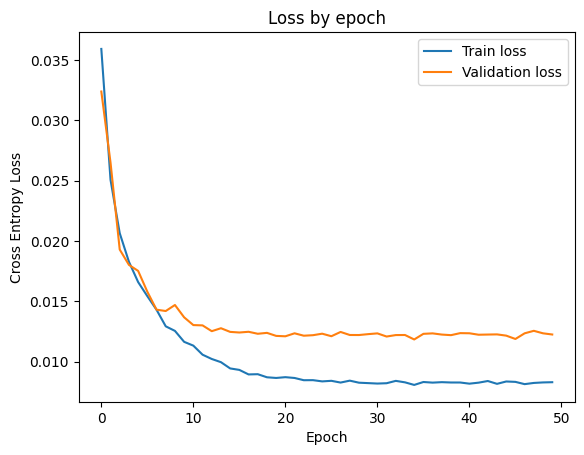

In [13]:
fig, ax1= plt.subplots(1,1)
ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross Entropy Loss")
plt.show()

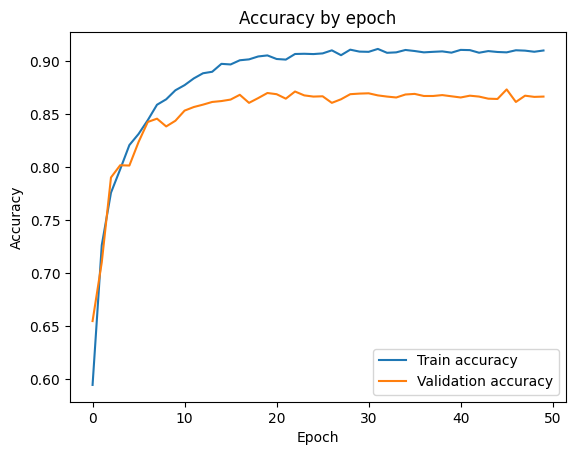

In [14]:
fig, ax1= plt.subplots(1,1)
ax1.plot(train_accuracy_by_epoch, label="Train accuracy")
ax1.plot(valid_accuracy_by_epoch, label="Validation accuracy")
ax1.legend()
ax1.set_title("Accuracy by epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
plt.show()

In [15]:
train_precision_by_epoch = np.array(train_precision_by_epoch)
train_recall_by_epoch = np.array(train_recall_by_epoch)

valid_precision_by_epoch = np.array(valid_precision_by_epoch)
valid_recall_by_epoch = np.array(valid_recall_by_epoch)

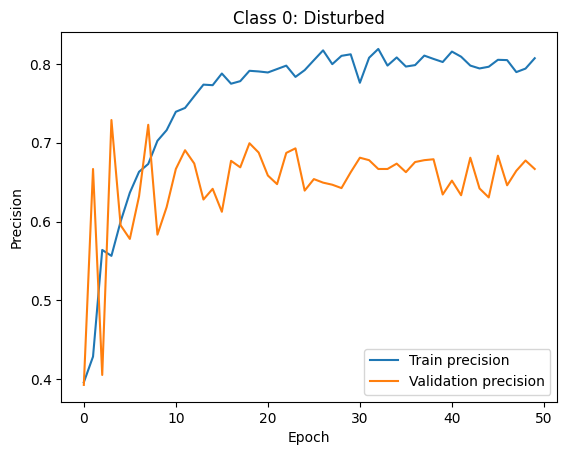

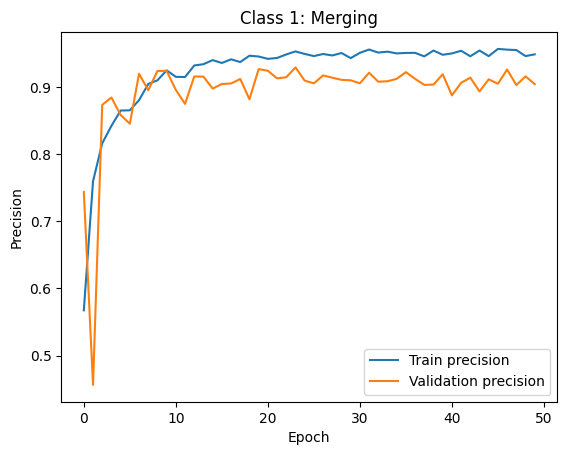

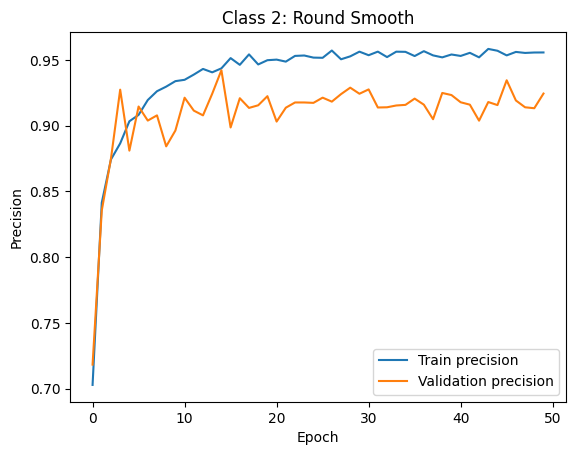

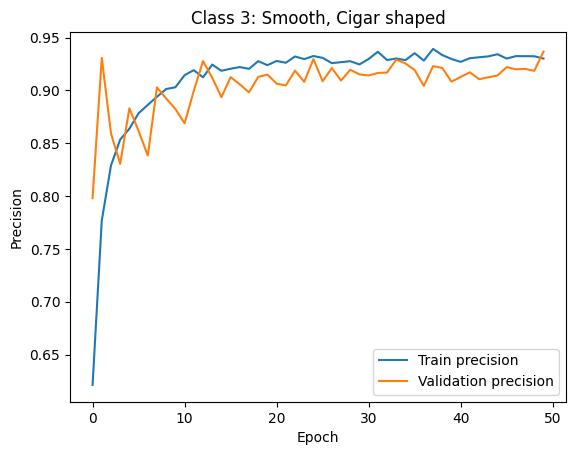

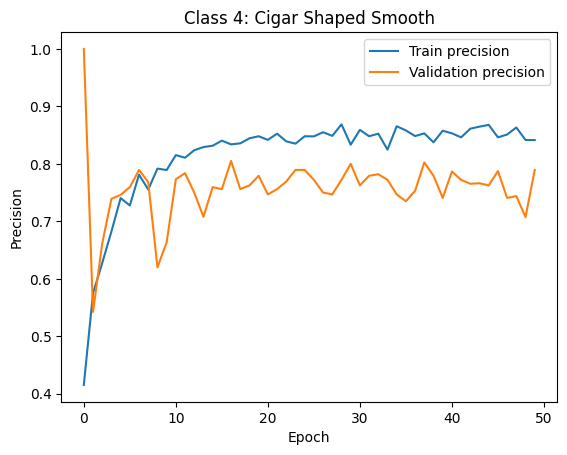

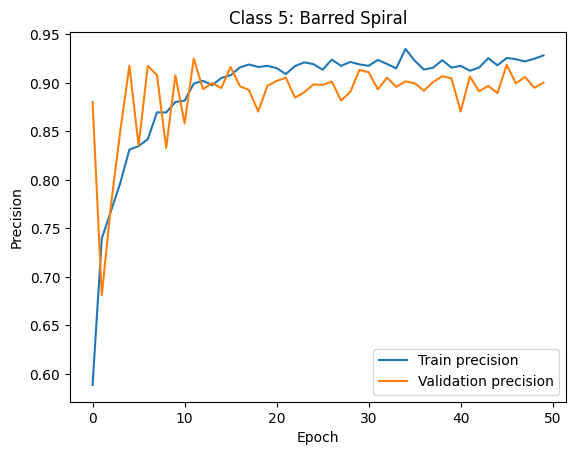

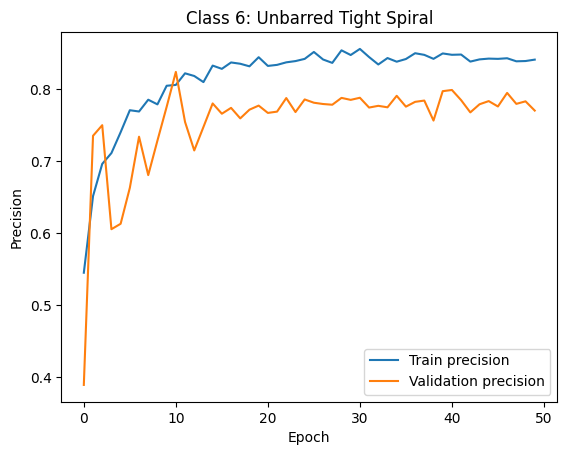

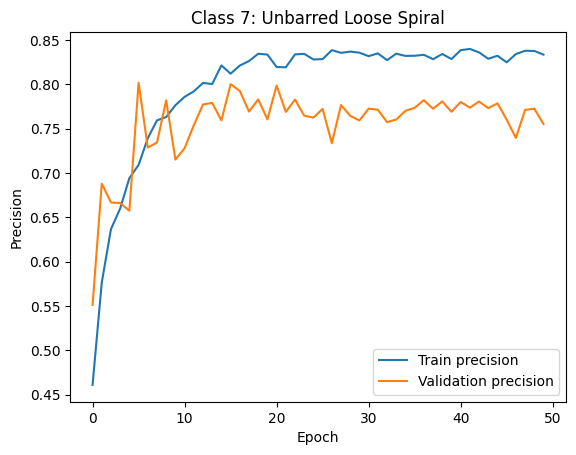

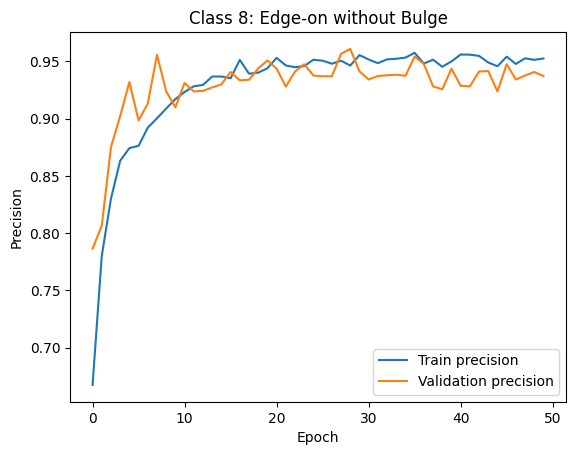

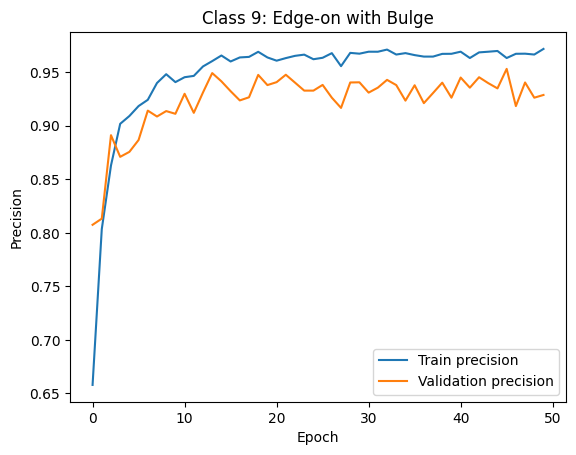

In [16]:
for i in range(10):
  fig, ax1 = plt.subplots(1,1)
  ax1.plot(train_precision_by_epoch[:, i], label="Train precision")
  ax1.plot(valid_precision_by_epoch[:, i], label="Validation precision")
  ax1.legend()
  ax1.set_title(f"Class {i}: {galaxy10.galaxy10cls_lookup(i)}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Precision")
  plt.show()

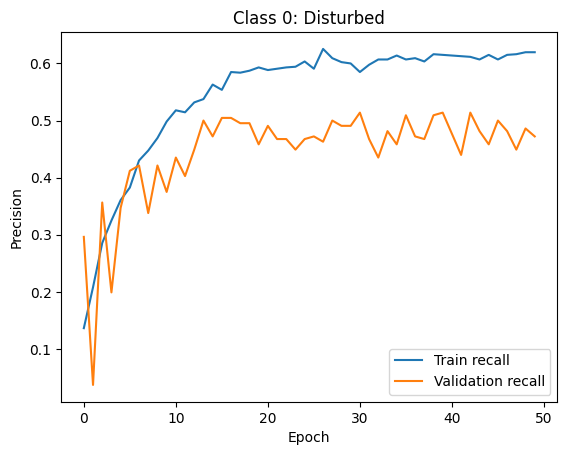

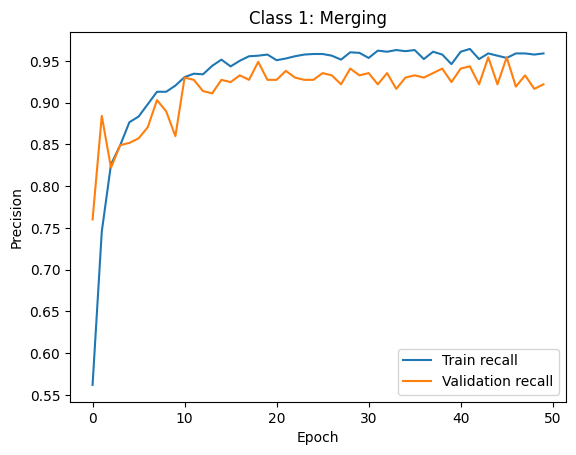

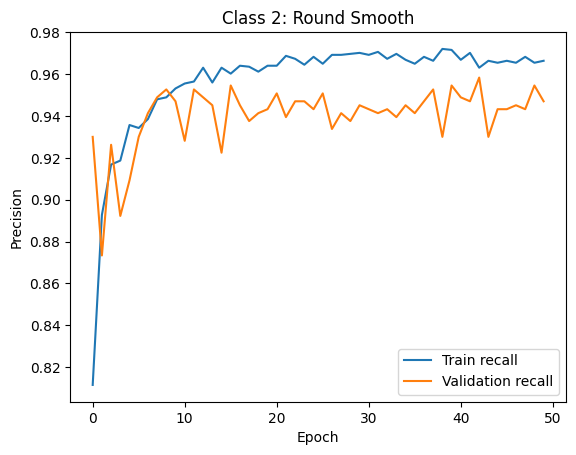

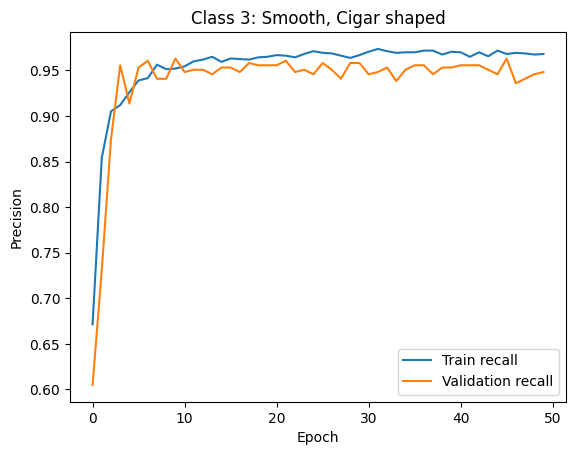

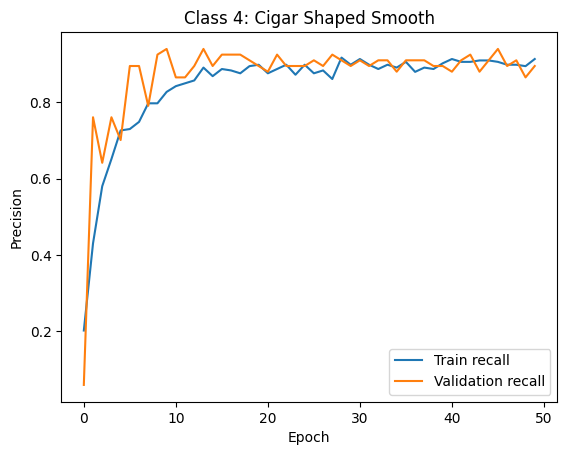

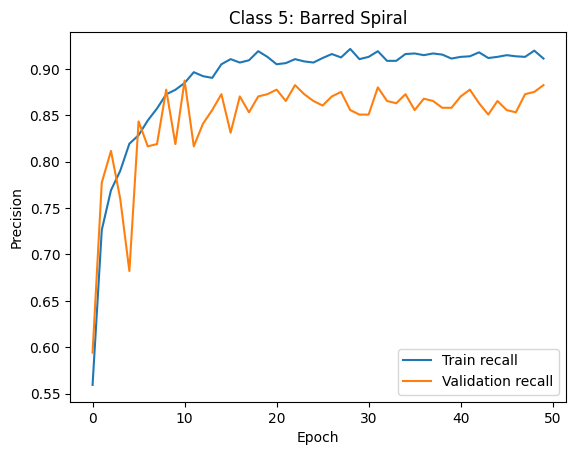

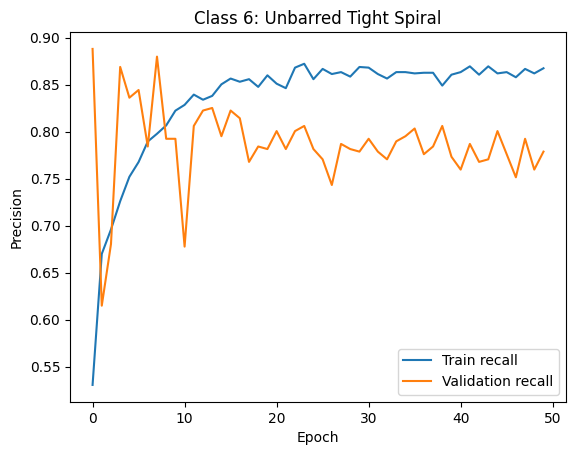

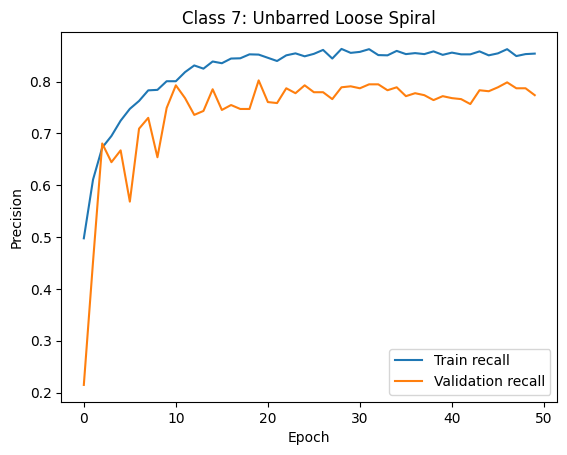

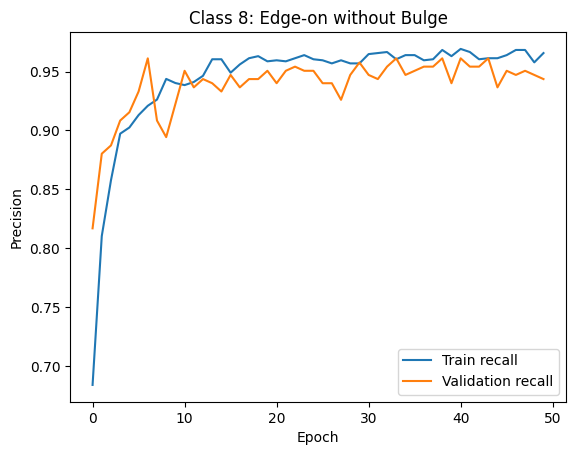

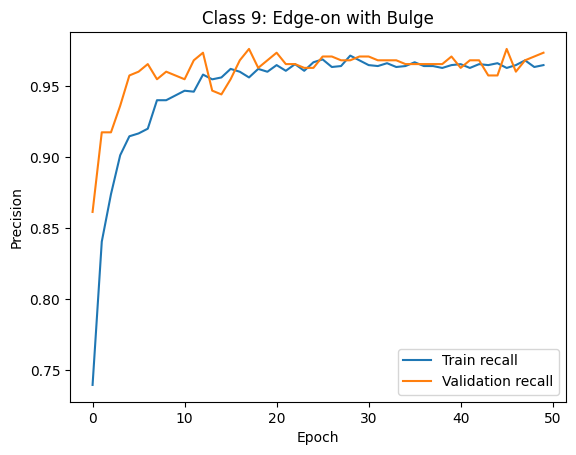

In [17]:
for i in range(10):
  fig, ax1 = plt.subplots(1,1)
  ax1.plot(train_recall_by_epoch[:, i], label="Train recall")
  ax1.plot(valid_recall_by_epoch[:, i], label="Validation recall")
  ax1.legend()
  ax1.set_title(f"Class {i}: {galaxy10.galaxy10cls_lookup(i)}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Precision")
  plt.show()